Arlington, Virginia has this great Bikeometer on the Custis Trail in Rosslyn. This tall digital sign always catches my attention when I ride by it. It displays the number of bicycles that pass that sign daily, monthly and year to date. I discovered that this data is also available online. I decided to use my Python skills to import this data, clean it up, and do some basic analysis.<!-- TEASER_END -->

Accoring to Arlington's website, the Rosslyn Bikeometer, the first Eco-Totem on the east coast, launched April 1, 2014. Westbound Lee Highway near N Lynn Street, Rosslyn. Bicycle-only detection and display is in real time with direction detection, four pavement loops.  You can find out more about it at http://www.bikearlington.com/pages/biking-in-arlington/counting-bikes-to-plan-for-bikes/about-the-counters/.

My first step in this project was to start this Python 3.5 Jupyter Notebook.  Then I import the libraries I plan to use for this project. They are as follows:

In [1]:
import pandas as pd
import requests
from xml.etree import ElementTree
import numpy as np

Then I created an API query to get the Rosslyn Bikeometer (counter number 28) from April 1, 2014 to January 1, 2017 for bicycles in the inbound direction.  For this first look at the data, I decided to only pull the daily totals. Using the url link, the following code uses Requests to get the url and save it to the local file, xml_data.xml. Arlington provides the details of their API at http://www.bikearlington.com/tasks/sites/bike/assets/File/Regional_bikearlington_webservices.pdf.


In [2]:
url = "http://webservices.commuterpage.com/counters.cfc?wsdl&method=GetCountInDateRange&counterid=28&startDate=04/01/2014&endDate=01/01/2017&direction=I&mode=B&interval=d"
xmlfile = open('xml_data.xml', 'w')
xmldata = requests.get(url)
xmlfile.write(xmldata.text)
xmlfile.close()

xml_data = 'xml_data.xml'

I took the XML data file and parsed it with ElementTree.

In [3]:
document = ElementTree.parse(xml_data)

After parsing the XML file, I pulled out the "count" data using document.find().

In [5]:
cnt = document.find('count')

Then you can extract the data using the attributes for count.  These include count, date, direction, and mode. For now, I only need count and date.

In [6]:
cnt.attrib['count']
cnt.attrib['date']
cnt.attrib['direction']

'I'

In [7]:
date = []
count = []
for day in document.findall('count'):
    date.append(day.attrib['date'])
    count.append(day.attrib['count'])
dfbikes = pd.DataFrame({'date' : date, 'count': count})
dfbikes['date'] = pd.to_datetime(dfbikes.date)
dfbikes.head()

,count,date
0,710,2014-04-01
1,688,2014-04-02
2,514,2014-04-03
3,424,2014-04-04
4,474,2014-04-05


The above dataframe can then be merged with other data for each of the dates listed. You can speed up this process by making the date field the index.

In [8]:
dfbikes = dfbikes.set_index("date")
dfbikes.head()

,count
date,
2014-04-01,710
2014-04-02,688
2014-04-03,514
2014-04-04,424
2014-04-05,474


## Adding in Weather Data

People typically consider weather conditions before deciding to take a bike trip. Thankfully, Arlington County also provides easy access to their local weather data via API.  The API details are provided below.

Source: http://webservices.commuterpage.com/weatherdata.cfc?wsdl&method=GetCodes

```xml
<weather_codes>
<code name="dewpoint" binary="No" cumulative="No" units="°F"/>
<code name="fog" binary="Yes" cumulative="No" units=""/>
<code name="hail" binary="Yes" cumulative="No" units=""/>
<code name="rain" binary="Yes" cumulative="No" units=""/>
<code name="snow" binary="Yes" cumulative="No" units=""/>
<code name="thunder" binary="Yes" cumulative="No" units=""/>
<code name="tornado" binary="Yes" cumulative="No" units=""/>
<code name="humidity" binary="No" cumulative="No" units="%"/>
<code name="pressure" binary="No" cumulative="No" units="inHg"/>
<code name="temperature" binary="No" cumulative="No" units="°F"/>
<code name="visibility" binary="No" cumulative="No" units="miles"/>
<code name="windspeed" binary="No" cumulative="No" units="mph"/>
<code name="precipitation" binary="No" cumulative="Yes" units="inches"/>
</weather_codes>

```


Description: Returns the weather data based on the requested weather code and the
date.
Request Fields:
• dates: string value, required field. Is a range of dates to retrieve the weather
data, acceptable format yyyymmdd-yyyymmdd
• code: string value, required field. Supply the available weather codes from the
getcodes response.
• function: string value, optional. Function to perform on the data (avg, sum, min,
max); defaults to avg.
• hours: string value, optional. Hours in 24-hour format (0-23); may be commadelimited
list, hyphen-separated range, or special keywords "all" or "daytime"
• dayLimiter: numeric value, optional. Day of the week. Sun to Sat – 1 to 7
respectively, weekends – 8, sat & sun – 9, All - 0. Defaults to All - 0.
Example:
http://webservices.commuterpage.com/weatherdata.cfc?wsdl&method=GetData&dates=20110301-20110305&code=temperature

In [10]:
weatherapi_url = "http://webservices.commuterpage.com/weatherdata.cfc?wsdl&method=GetData&dates=20140401-20170101&code=temperature"

In [11]:
xmlfile = open('xml_temps.xml', 'w')
xmldata = requests.get(weatherapi_url)
xmlfile.write(xmldata.text)
xmlfile.close()

xml_temps = 'xml_temps.xml'

In [12]:
document = ElementTree.parse(xml_temps)
date = []
temp = []

In [13]:
for day in document.findall('dataset/date'):
    date.append(day.attrib['value'])
for day in document.findall('dataset/date/data'):
    temp.append(day.attrib['value'])
dftemperature = pd.DataFrame({'date' : date, 'temperature' : temp})
dftemperature['date'] = pd.to_datetime(dftemperature.date)
dftemperature = dftemperature.set_index("date")
dftemperature.head()

,temperature
date,
2015-01-01,36.6
2016-01-01,41.9
2017-01-01,46.3
2015-01-02,41.4
2016-01-02,40.2


In [14]:
pd.concat([dfbikes, dftemperature], axis=1).head()

,count,temperature
date,,
2014-04-01,710,54.0
2014-04-02,688,55.3
2014-04-03,514,59.8
2014-04-04,424,55.1
2014-04-05,474,53.0


# Add in wind and precipitation

In [15]:
weatherapi_url = "http://webservices.commuterpage.com/weatherdata.cfc?wsdl&method=GetData&dates=20140401-20170101&code=windspeed"

xmlfile = open('xml_wind.xml', 'w')
xmldata = requests.get(weatherapi_url)
xmlfile.write(xmldata.text)
xmlfile.close()

xml_wind = 'xml_wind.xml'

In [16]:
document = ElementTree.parse(xml_wind)
date = []
wind = []

In [17]:
for day in document.findall('dataset/date'):
    date.append(day.attrib['value'])
for day in document.findall('dataset/date/data'):
    wind.append(day.attrib['value'])
dfwind = pd.DataFrame({'date' : date, 'windspeed' : wind})
dfwind['date'] = pd.to_datetime(dfwind.date)
dfwind = dfwind.set_index("date")
dfwind.head()

,windspeed
date,
2014-04-01,6
2014-04-02,3
2014-04-03,3
2014-04-04,7
2014-04-05,9


In [18]:
weatherapi_url = "http://webservices.commuterpage.com/weatherdata.cfc?wsdl&method=GetData&dates=20140401-20170101&code=precipitation"

xmlfile = open('xml_precip.xml', 'w')
xmldata = requests.get(weatherapi_url)
xmlfile.write(xmldata.text)
xmlfile.close()

xml_precip = 'xml_precip.xml'

In [19]:
document = ElementTree.parse(xml_precip)
date = []
precip = []

In [20]:
for day in document.findall('dataset/date'):
    date.append(day.attrib['value'])
for day in document.findall('dataset/date/data'):
    if day.attrib['value'] != 'T':
        precip.append(day.attrib['value'])
    else:
        precip.append(0.0)
dfprecip = pd.DataFrame({'date' : date, 'precipitation' : precip})
dfprecip['date'] = pd.to_datetime(dfprecip.date)
dfprecip = dfprecip.set_index("date")
dfprecip.head()

,precipitation
date,
2014-04-01,0.00
2014-04-02,0.00
2014-04-03,0
2014-04-04,0.06
2014-04-05,0.01


In [21]:
bikedataframe = pd.concat([dfbikes, dftemperature, dfwind, dfprecip], axis=1)
bikedataframe.head()

,count,temperature,windspeed,precipitation
date,,,,
2014-04-01,710,54.0,6,0.00
2014-04-02,688,55.3,3,0.00
2014-04-03,514,59.8,3,0
2014-04-04,424,55.1,7,0.06
2014-04-05,474,53.0,9,0.01


In [22]:
bikedataframe.index[0].weekday_name

'Tuesday'

In [23]:
bikedataframe["dayofweek"] = bikedataframe.index.dayofweek

In [24]:
bikedataframe = bikedataframe.astype(float)
bikedataframe["weekday"] = 0
bikedataframe['weekday'] = np.where(bikedataframe['dayofweek'] < 5, 1, 0)
bikedataframe.head(14)

,count,temperature,windspeed,precipitation,dayofweek,weekday
date,,,,,,
2014-04-01,710.0,54.0,6.0,0.00,1.0,1
2014-04-02,688.0,55.3,3.0,0.00,2.0,1
2014-04-03,514.0,59.8,3.0,0.00,3.0,1
2014-04-04,424.0,55.1,7.0,0.06,4.0,1
2014-04-05,474.0,53.0,9.0,0.01,5.0,0
2014-04-06,553.0,50.1,6.0,0.00,6.0,0
2014-04-07,165.0,51.0,6.0,0.38,0.0,1
2014-04-08,560.0,57.7,7.0,0.04,1.0,1
2014-04-09,653.0,57.3,7.0,0.00,2.0,1


In [24]:
bikedataframe.mean()

count            426.203980
temperature       61.207562
windspeed          7.176471
precipitation      0.112159
dayofweek          3.002979
weekday            0.714002
dtype: float64

As you can see from the mean data above, the average number of inbound bike trips per day was 426. It would then be interesting to see which days of the week had higher or lower than average bike usage.

In [25]:
bikedataframe.groupby('dayofweek').mean()

,count,temperature,windspeed,precipitation,weekday
dayofweek,,,,,
0.0,469.552448,61.428671,7.226950,0.126667,1
1.0,478.187500,62.140278,7.062500,0.169097,1
2.0,473.333333,61.881119,6.832168,0.139792,1
3.0,442.118881,61.536364,7.132867,0.105347,1
4.0,426.629371,60.450694,7.625000,0.070764,1
5.0,325.013889,60.023611,7.256944,0.121736,0
6.0,369.006944,61.000694,7.097222,0.052014,0


It looks like Monday (dayofweek = 0) through Thursday (dayofweek = 4) has higher than average usage and Saturday has the lowest average number of bike trips. It seems there might be a significant difference between weekday and weekend bike usage on the Custis Trail.

In [26]:
week_versus_end = bikedataframe.groupby('weekday')
week_versus_end['count'].mean()

weekday
0    347.010417
1    458.013947
Name: count, dtype: float64

The average daily weekday number of inbound bike trips was 458 versus just 347 per day on the weekends.

In [27]:
week_versus_end.min()

,count,temperature,windspeed,precipitation,dayofweek
weekday,,,,,
0,0.0,15.9,1.0,0.0,5.0
1,2.0,14.1,1.0,0.0,0.0


In [28]:
week_versus_end.max()

,count,temperature,windspeed,precipitation,dayofweek
weekday,,,,,
0,973.0,90.1,21.0,2.75,6.0
1,989.0,89.2,16.0,2.70,4.0


In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

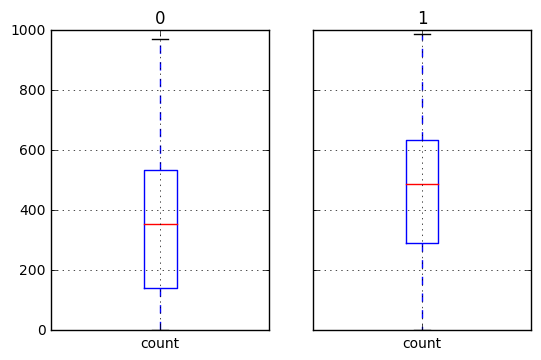

In [32]:
plt.figure()
bp = week_versus_end.boxplot(column = 'count', return_type='axes')

The boxplot of the left clearly shows that on average there are fewer bike trips on the weekend days versus weekdays. However, there are some weekend day outliers that are almost just as high as the weekday extreme usage days. There seems to be a daily maximum capacity for the trail around 1,000 inbound trips. It makes me think some of these extremely high outliers are associated with events.

My next steps will be to explore these extreme outliers, dig further into the temperature, wind and precipitation day. Ultimately, I want to build a model that can predict daily bike trips on this part of the Custis Trail.